### Language model
Building a character level language model using neural nets. Training is going to consist of using three characters to predict the fourth character

In [104]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Dataset with babynames
# The most common 32K names takes from ssa.gov for the year 2018
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [3]:
with open('names.txt', 'r') as file:
    names = file.read().split()

In [4]:
# Looking at few samples
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
# Total number of names
len(names)

32033

In [6]:
# Shortest name 
print(f'Shortest name has {min(len(name) for name in names)} letters')
# Longest name
print(f'Longest name has {max(len(name) for name in names)} letters')

Shortest name has 2 letters
Longest name has 15 letters


Names are in english language and only contain alphabets. We are going to use all the unique characters to create our vocabulary. We are going to use '.' as a placeholder to indicate start and end of a sequence of characters (name).

In [7]:
vocab = sorted(list(set(list(''.join(names))))) # sorted characters
delimiter = '.' 
vocab = [ delimiter ] + vocab
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [8]:
X, Y = [], []
block_size = 3
def create_data(block_size: int):
    """Create dataset for given block size"""
    for name in names:
        name = block_size * "." + name + "."
        name
        for idx in range(len(name) - block_size):
            start_idx = idx
            end_idx = idx + block_size
            X.append(tuple(name[start_idx:end_idx]))
            Y.append(name[block_size + start_idx])
create_data(block_size)

In [9]:
# Printing some outputs
for feat, targ in zip(X[:10], Y[:10]):
# for feat, targ in zip(X[-10:], Y[-10:]):
    print(f"{feat} --> {targ}")

('.', '.', '.') --> e
('.', '.', 'e') --> m
('.', 'e', 'm') --> m
('e', 'm', 'm') --> a
('m', 'm', 'a') --> .
('.', '.', '.') --> o
('.', '.', 'o') --> l
('.', 'o', 'l') --> i
('o', 'l', 'i') --> v
('l', 'i', 'v') --> i


In [10]:
# Converting characters to tokens 
stoi = {char: idx for idx, char in enumerate(vocab)} # char to int
itos = {idx: char for char, idx in stoi.items()}     # int to char

In [11]:
# Tokenize the data
X = [(stoi[first], stoi[second], stoi[third]) for first, second, third in X]
Y = [stoi[char] for char in Y]

In [12]:
# Visualizing after tokenization
for (feats, lab) in zip(X[:10], Y[:10]):
    print(f'{itos[feats[0]], itos[feats[1]], itos[feats[2]]} --> {itos[lab]}')

('.', '.', '.') --> e
('.', '.', 'e') --> m
('.', 'e', 'm') --> m
('e', 'm', 'm') --> a
('m', 'm', 'a') --> .
('.', '.', '.') --> o
('.', '.', 'o') --> l
('.', 'o', 'l') --> i
('o', 'l', 'i') --> v
('l', 'i', 'v') --> i


In [13]:
# Convert to tesnors
X = torch.tensor(X)
Y = torch.tensor(Y)

The size of the dataset is around 228k

In [14]:
len(X), len(Y)

(228146, 228146)

We are going to create an embedding matrix. Each row in the matrix is going to correspond to each character in the vocab. We will use 2 dimensions for embedding so that we can visualize them after training.

### Initialize weights 

In [99]:
# Creating the Embedding matrix
emb_mat = torch.randn((len(vocab), 2), requires_grad=True)
print(f'shape of embedding matric: {emb_mat.shape}')

input_dim = emb_mat[X[0]].view(-1).shape[-1]
vocab_size = len(vocab)
# Initialize weights with random numbers
wei = torch.randn(input_dim, vocab_size, requires_grad=True) # shape 6 x 27
bias = torch.randn(vocab_size, requires_grad=True)           # shape 27
print(f'shape of weights: {wei.shape}, bias: {bias.shape}')

# Collect updateable parameters
parameters = [wei, bias, emb_mat]

shape of embedding matric: torch.Size([27, 2])
shape of weights: torch.Size([6, 27]), bias: torch.Size([27])


Let's create some predictions to see what the randomly initialized weights output

In [82]:
def predict_next_token(num_names, longest_name=15):
    # Start with the delimiter token
    # Our model is a tri-gram model so needs three tokens to start
    start_tokens = emb_mat[stoi[delimiter]]
    # print(start_tokens.shape)
    # Join three tokens to create the starter triad
    start_tokens = torch.cat((start_tokens, start_tokens, start_tokens))
    # print(start_tokens.shape)
    
    with torch.no_grad():
        for _ in range(num_names): # Let's predict 20 names
            counter = 0
            while True:
                logits = start_tokens @ wei + bias
                probas = F.softmax(logits, dim=-1)
                # Always pick the highest predicted logit (Not a good idea as it becomes deterministic)
                next_idx = torch.multinomial(probas, 1, replacement=True).item()
                next_char = itos[next_idx]
                # print(f'start_tokens: {start_tokens}')
                print(next_char, end='')
                if counter != 0 and next_char == '.':
                    break
                next_token = emb_mat[next_idx]
                # Replace first two tokens by the last two
                first_two_tokens = start_tokens[2:].clone()
                start_tokens[:4] = first_two_tokens
                # Join predicted token to be fed to the model
                start_tokens[4:] = next_token
                counter += 1
                if counter == longest_name: break
            print()

In [91]:
predict_next_token(5)

vgltxsgvttsgcfo
deeqggxuggdxyov
ek.
bgkcurdoeggxuwg
lyxubdoryoegdxu


We are concatenating the embeddings of the three characters and feeding them to the model. In our case since we are using 2 embedding dimensions and three characters our model will expect 6 input features. We can accomplish this by manipulating the shape of the tensor with `.view(batch_size, -1)` method essentially flattening out the non-batch dimensions.  

In [33]:
# Embeddings for a sample
emb_mat[X[1]]

tensor([[ 0.7459,  0.4700],
        [ 0.7459,  0.4700],
        [ 0.6868, -1.0874]], grad_fn=<IndexBackward0>)

In [34]:
emb_mat[X[1]].view(-1)

tensor([ 0.7459,  0.4700,  0.7459,  0.4700,  0.6868, -1.0874],
       grad_fn=<ViewBackward0>)

In [64]:
# Test a few samples
samples = emb_mat[X[:10]].view(10, -1) # shape of samples 10 x 6
output = samples @ wei + bias
output.shape

torch.Size([10, 27])

In [65]:
loss = F.cross_entropy(output, Y[:10])

In [66]:
loss

tensor(5.2154, grad_fn=<NllLossBackward0>)

In [67]:
loss.backward()

In [69]:
emb_mat.grad.shape, wei.grad.shape, bias.grad.shape

(torch.Size([27, 2]), torch.Size([6, 27]), torch.Size([27]))

In [100]:
lr = 0.1
num_epochs = 1000

# Don't forget to initialize the parameters

for epoch in range(num_epochs):
    logits = emb_mat[X].view(len(X), -1) @ wei + bias
    loss = F.cross_entropy(logits, Y)
    loss.backward()

    for param in parameters:
        param.data -= lr * param.grad
        param.grad = None
    if not epoch % 100:
        print(f'epoch: {epoch}, loss: {loss:.4f}')
        print('----------------------------------')
        predict_next_token(5)
        print('==================================')

epoch: 0, loss: 5.9966
----------------------------------
ufnfnfifgfrooff
ctoffdfffdffffc
nfsfsfsksfsfnfs
fs.
fsfsuffkhcnynxf
epoch: 100, loss: 3.5020
----------------------------------
aupffpfftofnfwf
fvtfprcuxrfkyyv
fpffktpkivgfhfi
npfhtni.
gfsfrapwfpffffh
epoch: 200, loss: 3.1141
----------------------------------
cpkhkufsfna.
w.
ea.
.m.
iil.
epoch: 300, loss: 2.9714
----------------------------------
rafdislan.
elaamas.
fhmn.
jgwnio.
fpkn.
epoch: 400, loss: 2.8977
----------------------------------
aeeema.
an.
lbei.
zlexiiyy.
azjyyvit.
epoch: 500, loss: 2.8501
----------------------------------
hnrr.
cjeeawy.
fqsiey.
aa.
.gxrfjyln.
epoch: 600, loss: 2.8144
----------------------------------
alosabaalamxky.
aatjnaraag.
eia.
ueldqtqaehr.
syohe.
epoch: 700, loss: 2.7847
----------------------------------
ei.
lna.
yel.
eynipinfoiylam.
ysg.
epoch: 800, loss: 2.7586
----------------------------------
yysta.
rtnolizofytqjny
a.
l.
mbad.
epoch: 900, loss: 2.7350
----------------------------

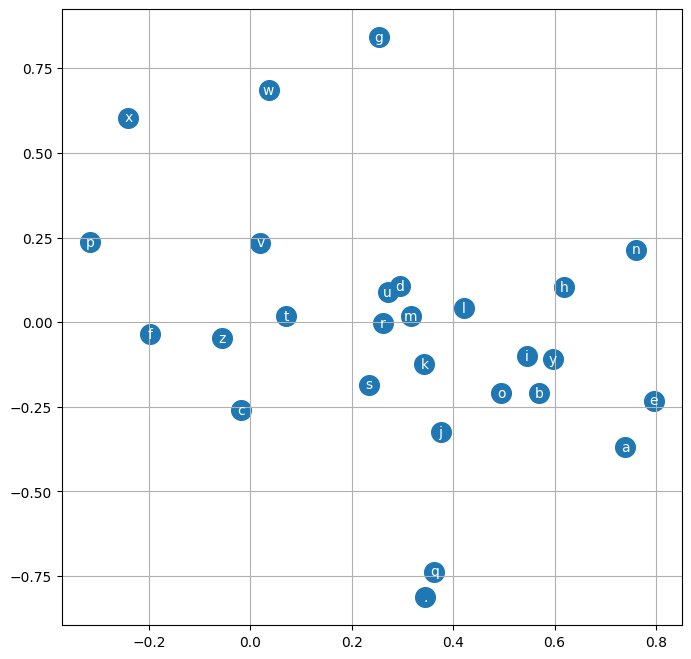

In [108]:
# visualize dimensions 0 and 1 of the embedding matrix emb_mat for all characters
plt.figure(figsize=(8,8))
plt.scatter(emb_mat[:,0].data, emb_mat[:,1].data, s=200)
for i in range(emb_mat.shape[0]):
    plt.text(emb_mat[i,0].item(), emb_mat[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

There is nothing to be proud of here. We created a linear model and asked it to model how characters are related in a name. Next step let's add another layer and use non-linearity between first and second layers

### Adding one additional layer and tanh non-linearity

In [238]:
# Creating the Embedding matrix
emb_dim = 10
emb_mat = torch.randn((len(vocab), emb_dim), requires_grad=True)
print(f'shape of embedding matric: {emb_mat.shape}')

input_dim = emb_mat[X[0]].view(-1).shape[-1]
hidden_dim = 100
vocab_size = len(vocab)
# Initialize weights with random numbers
wei_1 = torch.randn(input_dim, hidden_dim, requires_grad=True)     # shape 30 x 100 
bias_1 = torch.randn(hidden_dim, requires_grad=True)               # shape 100
wei_2 = torch.randn(hidden_dim, vocab_size, requires_grad=True)   # shape 100 x 27
bias_2 = torch.randn(vocab_size, requires_grad=True)               # shape 27

# Collect updateable parameters
parameters = [wei_1, bias_1, wei_2, bias_2, emb_mat]

for param in parameters: 
    print(f"{param.shape=}")

shape of embedding matric: torch.Size([27, 10])
param.shape=torch.Size([30, 100])
param.shape=torch.Size([100])
param.shape=torch.Size([100, 27])
param.shape=torch.Size([27])
param.shape=torch.Size([27, 10])


In [257]:
def predict_next_token(num_names, longest_name=15):
    # Start with the delimiter token
    # Our model is a tri-gram model so needs three tokens to start
    # start_tokens = emb_mat[stoi[delimiter]]
    # print(start_tokens.shape)
    # Join three tokens to create the starter triad
    # start_tokens = torch.cat((start_tokens, start_tokens, start_tokens))
    # print(start_tokens.shape)

    
    with torch.no_grad():
        for _ in range(num_names): 
            context = [0] * block_size
            out = []
            counter = 0
            
            while True:
                inputs = emb_mat[context].view(-1)       # shape of inputs batch x 6
                hidden = F.tanh(inputs @ wei_1 + bias_1)   # shape of hidden batch x 100
                logits = hidden @ wei_2 + bias_2           # shape of logits batch x 27
                probas = F.softmax(logits, dim=-1)
                # Always pick the highest predicted logit (Not a good idea as it becomes deterministic)
                next_idx = torch.multinomial(probas, 1, replacement=True).item()
                print(f'{context} -> {next_idx}')
                out.append(next_idx)
                # next_char = itos[next_idx]
                # print(f'start_tokens: {start_tokens}')
                # print(next_char, end='')
                if counter != 0 and next_idx == 0:
                    break
                # next_token = emb_mat[next_idx]
                # Replace first two tokens by the last two
                # first_two_tokens = start_tokens[2:].clone()
                # start_tokens[:4] = first_two_tokens
                # Join predicted token to be fed to the model
                # start_tokens[4:] = next_token
                context = context[1:]
                context.append(next_idx)
                counter += 1
                if counter == longest_name: break
            print(''.join([itos[i] for i in out]))
predict_next_token(1)

[0, 0, 0] -> 19
[0, 0, 19] -> 1
[0, 19, 1] -> 25
[19, 1, 25] -> 10
[1, 25, 10] -> 15
[25, 10, 15] -> 18
[10, 15, 18] -> 5
[15, 18, 5] -> 0
sayjore.


In [239]:
# predictions from a random model
predict_next_token(5)

unnsslcdzjcxs.
.ueiztshddnbesl
jcdnyevodvxsexa
mhdnnestbcmveul
wcntetqwdvxkkho


In [240]:
stepi = []
lossi = []

In [241]:
lr = 0.1
steps = 200000
batch_size = 32

# Don't forget to initialize the parameters

for i in range(steps):
    idx = torch.randint(0, X.shape[0] - 1, size=(batch_size,))

    inputs = emb_mat[X[idx]].view(len(idx), -1)       # shape of inputs batch x 30
    hidden = F.tanh(inputs @ wei_1 + bias_1)   # shape of hidden batch x 100
    logits = hidden @ wei_2 + bias_2           # shape of logits batch x 27
    loss = F.cross_entropy(logits, Y[idx])
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad
        param.grad = None
    stepi.append(i)
    lossi.append(loss)
    # if not epoch % 100:
    #     print(f'epoch: {epoch}, loss: {loss:.4f}')
    #     print('----------------------------------')
    #     predict_next_token(5)
    #     print('==================================')

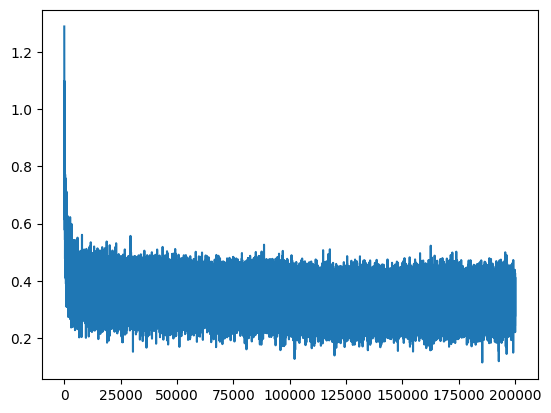

In [242]:
plt.plot(stepi, [i.log10().item() for i in lossi]);

In [243]:
inputs = emb_mat[X].view(len(X), -1)       # shape of inputs batch x 30
hidden = F.tanh(inputs @ wei_1 + bias_1)   # shape of hidden batch x 100
logits = hidden @ wei_2 + bias_2           # shape of logits batch x 27
loss = F.cross_entropy(logits, Y)
print(loss)

tensor(2.1562, grad_fn=<NllLossBackward0>)


In [246]:
predict_next_token(20)

wloe.
m.
on.
.ajmelin.
.kor.
d.
inzius.
..
.zis.
ham.
.komonte.
elusteyd.
en.
.kean.
na.
h.
.aja.
ianna.
..
.aalya.


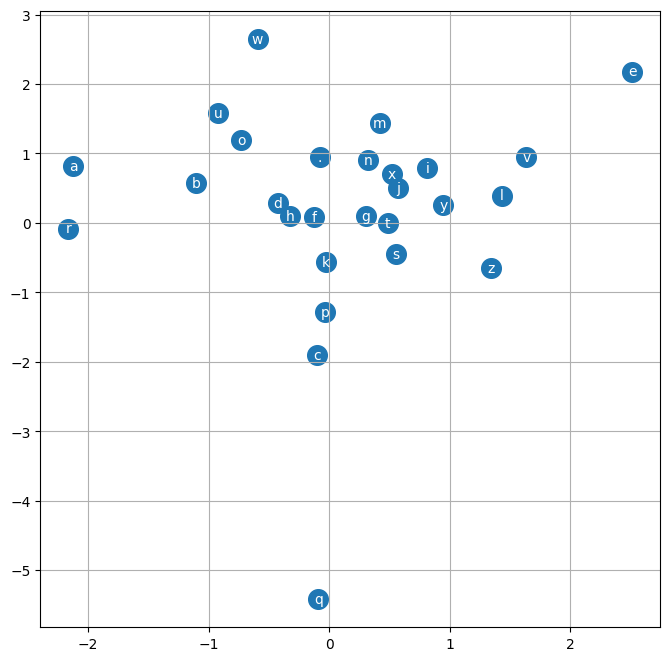

In [237]:
# visualize dimensions 0 and 1 of the embedding matrix emb_mat for all characters
plt.figure(figsize=(8,8))
plt.scatter(emb_mat[:,0].data, emb_mat[:,1].data, s=200)
for i in range(emb_mat.shape[0]):
    plt.text(emb_mat[i,0].item(), emb_mat[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')